In [6]:
import functools
import time
import math
import tensorflow as tf
from tensorflow import keras
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Defining Constants

In [7]:
DEVICE = 'GPU/:0'

DATASET_DIR = '../../../datasets/Dataset-IoT/'
NETFLOW_DIR = DATASET_DIR + 'MC/NetFlow/'

# MC_I_FIRST: Has infected data by Hajime, Aidra and BashLite botnets'
# MC_I_SECOND: Has infected data from Mirai botnets
# MC_I_THIR: Has infected data from Mirai, Doflo, Tsunami and Wroba botnets
# MC_L: Has legitimate data, no infection
MC_L = r'MC_L.csv'

data_set_files = [r'MC_I{}.csv'.format(index) for index in range(1, 4)]
data_set_files.insert(0, r'MC_L.csv')
print (data_set_files)

['MC_L.csv', 'MC_I1.csv', 'MC_I2.csv', 'MC_I3.csv']


Loading the Dataset

In [8]:
legitimate_file_path = NETFLOW_DIR + MC_L

LABEL_COLUMN = 'Label'

#reading data
df = pd.read_csv (legitimate_file_path)

# for file in data_set_files:
#     aux_df = pd.read_csv(NETFLOW_DIR + file)
#     df = pd.concat([df, aux_df], ignore_index=True)

aux_df = pd.read_csv(NETFLOW_DIR + data_set_files[1])
df = pd.concat([df, aux_df], ignore_index=True)

#making the final DataFrame
df = df.drop(df.columns[0], axis=1)
df.describe()

nUniques = df.nunique()
for column, nUnique in zip (df.columns, nUniques):
    if(nUnique == 1):
        df.drop(axis='columns', columns=column, inplace=True)
df

,Label,ts,te,td,sa,da,sp,dp,pr,flg,ipkt,ibyt
45550,1,2018-11-11 03:30:57,2018-11-11 03:30:57,0.000,192.168.1.109,166.193.12.96,1342,23.0,TCP,....S.,1.0,40.0
281185,1,2018-11-11 03:59:16,2018-11-11 03:59:16,0.000,192.168.1.109,117.70.91.112,55439,23.0,TCP,....S.,1.0,40.0
261119,1,2018-11-11 03:56:46,2018-11-11 03:56:46,0.000,192.168.1.109,119142156234,9843,23.0,TCP,....S.,1.0,40.0
120102,1,2018-11-11 03:39:45,2018-11-11 03:39:45,0.000,192.168.1.109,71.226.169.55,17221,23.0,TCP,....S.,1.0,40.0
253760,1,2018-11-11 03:55:53,2018-11-11 03:55:53,0.000,192.168.1.109,197.218.253.95,22566,81.0,TCP,....S.,1.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...
329492,1,2018-11-11 04:05:12,2018-11-11 04:05:12,0.000,192.168.1.109,77.244.39.247,34905,81.0,TCP,....S.,1.0,40.0
330917,1,2018-11-11 04:05:22,2018-11-11 04:05:22,0.000,192.168.1.109,220.169.97.46,17755,81.0,TCP,....S.,1.0,40.0
237333,1,2018-11-11 03:54:42,2018-11-11 03:54:49,6.363,121.243.183.55,192.168.1.109,23,60430.0,TCP,.AP.SF,13.0,665.0
6371,1,2018-11-11 03:26:21,2018-11-11 03:26:21,0.000,192.168.1.109,52251158154,15964,81.0,TCP,....S.,1.0,40.0


In [10]:
df.drop(axis='columns', columns=['ts', 'te', 'sa', 'da'], inplace=True)
df

,Label,td,sp,dp,pr,flg,ipkt,ibyt
45550,1,0.000,1342,23.0,TCP,....S.,1.0,40.0
281185,1,0.000,55439,23.0,TCP,....S.,1.0,40.0
261119,1,0.000,9843,23.0,TCP,....S.,1.0,40.0
120102,1,0.000,17221,23.0,TCP,....S.,1.0,40.0
253760,1,0.000,22566,81.0,TCP,....S.,1.0,40.0
...,...,...,...,...,...,...,...,...
329492,1,0.000,34905,81.0,TCP,....S.,1.0,40.0
330917,1,0.000,17755,81.0,TCP,....S.,1.0,40.0
237333,1,6.363,23,60430.0,TCP,.AP.SF,13.0,665.0
6371,1,0.000,15964,81.0,TCP,....S.,1.0,40.0


# Encoding the Categorical Columns

In [10]:
from sklearn import preprocessing

cat_cols, num_cols = df.columns[df.dtypes == 'O'], df.columns[df.dtypes != 'O']
num_cols = num_cols[1:]

categories = [df[column].unique() for column in df[cat_cols]]

categorical_encoder = preprocessing.OrdinalEncoder(categories=categories)
categorical_encoder.fit(df[cat_cols])
df[cat_cols] = categorical_encoder.transform(df[cat_cols])

df

,Label,ts,te,td,sa,da,sp,dp,pr,flg,ipkt,ibyt
135375,1,0.0,0.0,0.0,0.0,0.0,30878,81.0,0.0,0.0,1.0,40.0
291020,1,1.0,1.0,0.0,0.0,1.0,52614,23.0,0.0,0.0,1.0,40.0
277805,1,2.0,2.0,0.0,0.0,2.0,26154,81.0,0.0,0.0,1.0,40.0
309491,1,3.0,3.0,0.0,0.0,3.0,42285,81.0,0.0,0.0,1.0,40.0
180108,1,4.0,4.0,0.0,0.0,4.0,62926,23.0,0.0,0.0,1.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...
207259,1,1238.0,194.0,0.0,0.0,329108.0,57449,23.0,0.0,0.0,1.0,40.0
150743,1,829.0,835.0,0.0,0.0,329109.0,55563,81.0,0.0,0.0,1.0,40.0
204483,1,1786.0,1781.0,0.0,0.0,329110.0,26855,81.0,0.0,0.0,1.0,40.0
72179,1,425.0,429.0,0.0,0.0,329111.0,60559,81.0,0.0,0.0,1.0,40.0


# Splitting the Data

In [11]:
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

train, test = train_test_split (df, test_size=0.2)
train, val = train_test_split (train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

train_labels = np.array (train.pop('Label'))
bool_train_labels = train_labels != 0
val_labels = np.array(val.pop('Label'))
test_labels = np.array (test.pop('Label'))

train_features = np.array(train)
val_features = np.array(val)
test_features = np.array(test)

230794 train examples
57699 validation examples
72124 test examples


How imbalanced is the data?

In [12]:
neg, pos = np.bincount(df['Label'])
print ("Negative Examples: {}".format(neg))
print ("Positive Examples: {}".format(pos))

#dropping the labels columns
df = df.drop(df.columns[0], axis=1)

Negative Examples: 2005
Positive Examples: 358612


# Scaling the Data

In [13]:
#getting the index of the numerical columns
index = [df.columns.get_loc(c) for c in num_cols]
index = np.array(index)

cat_index = [df.columns.get_loc(c) for c in cat_cols]
cat_index = np.array(index)

scaler = StandardScaler()
train_features[:, index] = scaler.fit_transform(train_features[:, index])

val_features[:, index] = scaler.transform(val_features[:, index])

test_features[:, index] = scaler.transform(test_features[:, index])

train_features[:, index] = np.clip(train_features[:, index], -5, 5)
val_features[:, index] = np.clip(val_features[:, index], -5, 5)
test_features[:, index] = np.clip(test_features[:, index], -5, 5)

# Creating the Model

In [33]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


def make_model(metrics = METRICS, output_bias=None, hidden_layer_size=32):
  
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
   
    model = keras.Sequential([
        keras.layers.Dense(hidden_layer_size, activation='relu', input_shape=(train_features.shape[-1],)),#, kernel_initializer=initializer),
        keras.layers.Dense(hidden_layer_size, activation='relu'),#, kernel_initializer=initializer),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(hidden_layer_size, activation='relu'),#, kernel_initializer=initializer),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)#, kernel_initializer=initializer)

    ])

    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)
    
    return model

In [34]:
model = make_model()
BATCH_SIZE = 2048

results = model.evaluate (train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print ("Loss: {:0.4f}".format(results[0]))

Loss: 14017.7305


# Dealing with the Imbalanced data

In [35]:
total = pos + neg
weight_for_0 = (1/neg)*(total)/2.0
weight_for_1 = (1/pos)*(total)/2.0

class_weight={0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 89.93
Weight for class 1: 0.50


# Running the Model

In [36]:
EPOCHS = 10
#we need a bigger batch_size to reduce the effects of the imbalanced data
BATCH_SIZE = 2048

initial_bias = np.log([neg/pos])

with tf.device (DEVICE):
    weighted_model = make_model(output_bias=initial_bias)
    weighted_history = weighted_model.fit(
        train_features,
        train_labels,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(val_features, val_labels),
        class_weight=class_weight)



Epoch 1/10
113/113 [==============================] - 1s 10ms/step - loss: 668.5006 - tp: 182321.0000 - fp: 532.0000 - tn: 2044.0000 - fn: 276691.0000 - accuracy: 0.3994 - precision: 0.9971 - recall: 0.3972 - auc: 0.5946 - val_loss: 7.3581 - val_tp: 53084.0000 - val_fp: 72.0000 - val_tn: 258.0000 - val_fn: 4285.0000 - val_accuracy: 0.9245 - val_precision: 0.9986 - val_recall: 0.9253 - val_auc: 0.8568
Epoch 2/10
113/113 [==============================] - 1s 5ms/step - loss: 66.5005 - tp: 185156.0000 - fp: 303.0000 - tn: 985.0000 - fn: 44350.0000 - accuracy: 0.8065 - precision: 0.9984 - recall: 0.8068 - auc: 0.7900 - val_loss: 12.3579 - val_tp: 44750.0000 - val_fp: 32.0000 - val_tn: 298.0000 - val_fn: 12619.0000 - val_accuracy: 0.7807 - val_precision: 0.9993 - val_recall: 0.7800 - val_auc: 0.8520
Epoch 3/10
113/113 [==============================] - 1s 5ms/step - loss: 20.7383 - tp: 182355.0000 - fp: 282.0000 - tn: 1006.0000 - fn: 47151.0000 - accuracy: 0.7945 - precision: 0.9985 - recal

Plotting function

In [22]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

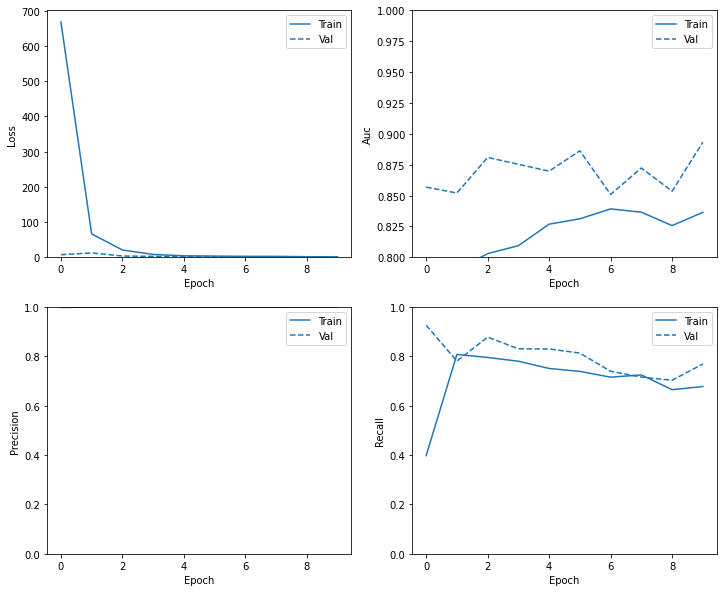

In [37]:
plot_metrics(weighted_history)

In [14]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  3.1120972633361816
tp :  49599.0
fp :  63.0
tn :  268.0
fn :  7769.0
accuracy :  0.8642610907554626
precision :  0.9987314343452454
recall :  0.8645760416984558
auc :  0.8502431511878967

Legitimate Transactions Detected (True Negatives):  268
Legitimate Transactions Incorrectly Detected (False Positives):  63
Fraudulent Transactions Missed (False Negatives):  7769
Fraudulent Transactions Detected (True Positives):  49599
Total Fraudulent Transactions:  57368


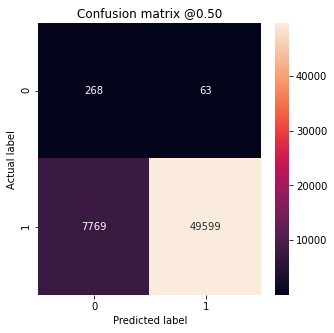

In [27]:
val_predictions_weighted = weighted_model.predict(val_features, batch_size=BATCH_SIZE)

weighted_results = weighted_model.evaluate(val_features, val_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(val_labels, val_predictions_weighted)